In [1]:
import xarray as xr
import numpy as np
from openap import top, aero
from matplotlib.colors import TwoSlopeNorm

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from cartopy.feature import OCEAN, LAND, BORDERS

from openap.top import tools
from openap.top import vis


## Load grid based data

Here, I use the climate aCCF data as the test. The trajectory will minimize the combined climate effort

(Note: this is not necessary a good source of grid cost function for trajectory optimization)

In [2]:
d = xr.open_dataset("../tmp/climaccf_20180601.nc")

df_cost = (
    d.to_dataframe()
    .query("-10<longitude<30 and 35<latitude<60 and level<800")
    .reset_index()
    .assign(h=lambda d: aero.h_isa(d.level * 100))
    .query("time=='2018-06-01T06:00:00'")
    .sort_values(["longitude", "latitude", "h"])
)


## Set up the new objective function

General steps to set you own objective function / cost grid:

1. generate the interpolate model (linear) based on the grid data
2. define the objective function
3. pass the new objective function and interplant model to optimizer's `trajectory()` generator

(Note: this process can take a while, ~1 minute with a modern computer)

In [3]:
optimizer = top.Cruise("A320", "EHAM", "LGAV", m0=0.85)
optimizer.init_conditions(h_min=32_000 * aero.ft, h_max=36_000 * aero.ft)
optimizer.fix_cruise_altitude()
optimizer.setup_dc(nodes=60)
optimizer.debug = False


interp_ccf = tools.interp_grid(
    df_cost.longitude.unique(),
    df_cost.latitude.unique(),
    df_cost.h.unique(),
    df_cost.aCCF_merged,
    shape="linear",
)


def obj_ccf(x, u, dt, **kwargs):
    value = optimizer.obj_grid_cost(x, u, dt, **kwargs)
    fuel = optimizer.obj_fuel(x, u, dt, **kwargs)
    scale = 10000 # the scale of objective is a mystery
    return value * fuel * scale


flight = optimizer.trajectory(
    objective=obj_ccf,
    interpolant=interp_ccf,
    h_min=32_000 * aero.ft,
    h_max=36_000 * aero.ft,
)


## Visualize the trajectory

<module 'matplotlib.pyplot' from '/var/mambaforge/envs/openap/lib/python3.11/site-packages/matplotlib/pyplot.py'>

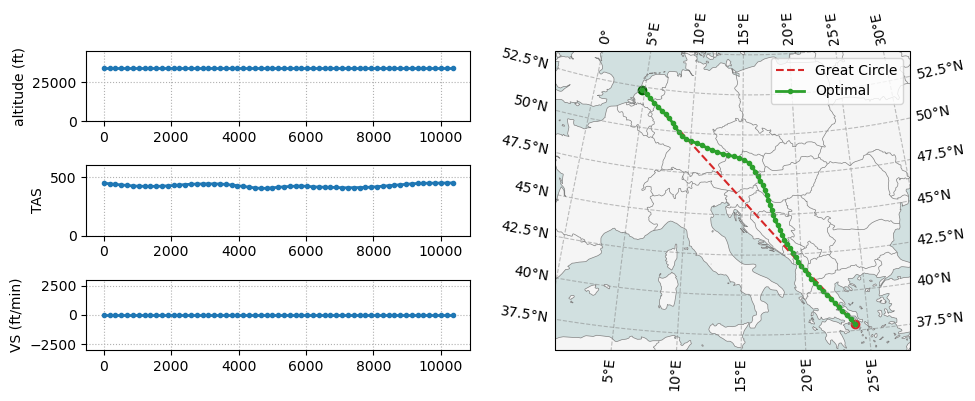

In [4]:
vis.trajectory(flight)


### Visualize with the cost grid

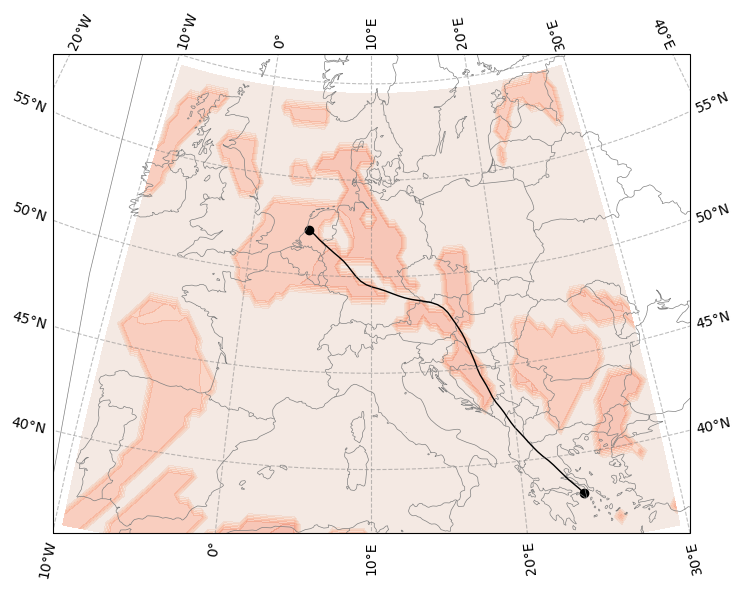

In [5]:
idx = np.abs(df_cost.h.unique() - flight.h.mean()).argmin()
level = df_cost.level.unique()[idx]

fig, ax = plt.subplots(
    1,
    1,
    figsize=(8, 6),
    subplot_kw=dict(
        projection=ccrs.TransverseMercator(central_longitude=10, central_latitude=50)
    ),
)

vmin = df_cost.aCCF_merged.min()
vmax = df_cost.aCCF_merged.max()


ax.set_extent([-10, 30, 35, 60])
ax.add_feature(BORDERS, lw=0.5, color="gray")
ax.gridlines(draw_labels=True, color="gray", alpha=0.5, ls="--")
ax.coastlines(resolution="50m", lw=0.5, color="gray")

df_cost_pivot = df_cost.query(f"level=={level}").pivot(
    index="latitude", columns="longitude", values="aCCF_merged"
)

lat, lon, val = df_cost_pivot.index.values, df_cost_pivot.columns.values, df_cost_pivot.values

ax.contourf(
    lon,
    lat,
    val,
    transform=ccrs.PlateCarree(),
    alpha=0.5,
    cmap="coolwarm",
    norm=TwoSlopeNorm(0),
    vmin=vmin,
    vmax=vmax,
)

h = aero.h_isa(level * 100)
f = flight.query(f"{h-500}<h<{h+500}")

ax.plot(flight.lon, flight.lat, color="k", lw=1, transform=ccrs.PlateCarree())

ax.scatter(flight.lon.iloc[0], flight.lat.iloc[0], c="k", transform=ccrs.PlateCarree())
ax.scatter(flight.lon.iloc[-1], flight.lat.iloc[-1], c="k", transform=ccrs.PlateCarree())

plt.tight_layout()
